In [412]:
# Cell 1: Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [414]:
df_beh = pd.read_csv(r'поведенческие_паттерны_клиентов_3.csv', encoding="cp1251", delimiter=';', skiprows=1)

In [415]:
df =  pd.read_csv(r'транзакции_в_Мобильном_интернет_Банкинге.csv', encoding="cp1251", delimiter=';', skiprows=1)

### Объединяем датасеты по дате и айди клиента

In [417]:
# 1. Привести названия колонок к единому формату
# В первом датафрейме переименовать колонку для join
df_beh = df_beh.rename(columns={'translate': 'transdate'})

# 2. Убедиться, что cst_dim_id в одинаковом формате
df_beh['cst_dim_id'] = df_beh['cst_dim_id'].astype(str)
df['cst_dim_id'] = df['cst_dim_id'].astype(str)

# 3. Привести даты к одинаковому формату (если нужно)
df_beh['transdate'] = pd.to_datetime(df_beh['transdate'])
df['transdate'] = pd.to_datetime(df['transdate'])

# 4. Выполнить join
result = pd.merge(
    df, 
    df_beh, 
    on=['transdate', 'cst_dim_id'], 
    how='inner'  # или 'left' в зависимости от задачи
)
    
# Посмотреть результат
result.head()

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d
0,2937833270.0,2025-01-05,'2025-01-05 16:32:02.000',31000.0,5343,8406e407421ec28bd5f445793ef64fd1,0,1,1,"iPhone16,1",...,1.5333333333333334,0.21118012422360244,0.282609,49814.117647,106759.606690,11397613620.705883,18227.846189,0.363698,228802.880771,-0.213134
1,2096229005.0,2025-03-04,'2025-03-04 17:41:57.000',4000.0,8442,b3a3d4a6006293195d998957d4f01e42,0,1,1,Samsung SM-S918B,...,1.7666666666666666,-0.11051212938005389,0.207547,50667.857143,78912.726908,6227218468.051948,6872.638130,0.217971,122902.739907,0.026791
2,2933493153.0,2025-07-06,'2025-07-06 14:52:13.000',500.0,11685,d677d4e1a0f625e1ad746ea950c9dca9,0,0,0,Vivo_v2339,...,0.0,NaN,NaN,1350.000000,1824.335495,3328200.0,-1.000000,0.149428,2465.333333,-1.000000
3,456000634.0,2024-12-18,'2024-12-18 14:12:25.000',20000.0,7128,87b698d1edae13c21ce86678de3b8546,0,1,1,Samsung SM-A536E,...,0.43333333333333335,1.3076923076923077,0.538462,213360.000000,425545.970020,"1,81E+11",127828.033176,0.332108,848750.340270,-0.408581
4,456175450.0,2025-08-02,'2025-08-02 14:27:41.000',18000.0,11883,ba51c27740a3fa59e298274df7380ef2,0,2,2,"iPhone15,2",...,0.9,1.2222222222222223,0.518519,92747.586207,129831.512839,16856221726.108374,7214.001911,0.166610,181742.969445,-0.402604


In [418]:
result.shape

(12762, 24)

# Data Cleaning 

### Проверяем, является ли docno уникальным

In [421]:
result['docno'].value_counts()

docno
12955    4
6882     4
5555     4
12296    4
814      4
        ..
1579     1
4781     1
5914     1
8855     1
6783     1
Name: count, Length: 12735, dtype: int64

### удаляем дубликаты

In [423]:
duplicates = result[result['docno'].duplicated(keep=False)]
duplicates

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d
1024,472228959.0,2025-02-05,'2025-02-05 13:53:47.000',360000.0,10447,4985f7c20172ad98985010c73c2509bf,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,74067.692308,157829.610559,24910185969.23077,178.553715,0.361203,336316.485543,0.203437
1025,472228959.0,2025-02-05,'2025-02-05 13:53:47.000',360000.0,10447,4985f7c20172ad98985010c73c2509bf,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,74067.692308,157829.610559,24910185969.23077,618.209198,0.361203,336316.485543,0.203437
1026,472228959.0,2025-02-05,'2025-02-05 13:53:47.000',360000.0,10447,4985f7c20172ad98985010c73c2509bf,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,110380.000000,255885.426208,65477351345.454544,178.553715,0.397268,593199.414255,-0.430603
1027,472228959.0,2025-02-05,'2025-02-05 13:53:47.000',360000.0,10447,4985f7c20172ad98985010c73c2509bf,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,110380.000000,255885.426208,65477351345.454544,618.209198,0.397268,593199.414255,-0.430603
1527,472228959.0,2025-02-05,'2025-02-05 16:53:58.000',5000.0,7040,abd8afd2a2550aab8cd446b2a9ca2c4c,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,74067.692308,157829.610559,24910185969.23077,178.553715,0.361203,336316.485543,0.203437
1528,472228959.0,2025-02-05,'2025-02-05 16:53:58.000',5000.0,7040,abd8afd2a2550aab8cd446b2a9ca2c4c,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,74067.692308,157829.610559,24910185969.23077,618.209198,0.361203,336316.485543,0.203437
1529,472228959.0,2025-02-05,'2025-02-05 16:53:58.000',5000.0,7040,abd8afd2a2550aab8cd446b2a9ca2c4c,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,110380.000000,255885.426208,65477351345.454544,178.553715,0.397268,593199.414255,-0.430603
1530,472228959.0,2025-02-05,'2025-02-05 16:53:58.000',5000.0,7040,abd8afd2a2550aab8cd446b2a9ca2c4c,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,110380.000000,255885.426208,65477351345.454544,618.209198,0.397268,593199.414255,-0.430603
2215,472228959.0,2025-02-05,'2025-02-05 08:24:41.000',5000.0,8358,abd8afd2a2550aab8cd446b2a9ca2c4c,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,74067.692308,157829.610559,24910185969.23077,178.553715,0.361203,336316.485543,0.203437
2216,472228959.0,2025-02-05,'2025-02-05 08:24:41.000',5000.0,8358,abd8afd2a2550aab8cd446b2a9ca2c4c,0,1,1,"iPhone14,5",...,0.43333333333333335,0.6483516483516484,0.384615,74067.692308,157829.610559,24910185969.23077,618.209198,0.361203,336316.485543,0.203437


### Удаляем все записи при дублировании docno, чтобы избежать попадания некорректных данных, т.к. при одинаковом идентиикаторе получаем разные значения переменных. 

In [425]:
result = result[~result['docno'].duplicated(keep=False)]

In [426]:
result.shape

(12724, 24)

### Проверяем пропущенные значения показателей

In [428]:
result.isna().sum()

cst_dim_id                       0
transdate                        0
transdatetime                    0
amount                           0
docno                            0
direction                        0
target                           0
monthly_os_changes               0
monthly_phone_model_changes      0
last_phone_model_categorical     0
last_os_categorical              0
logins_last_7_days               0
logins_last_30_days              0
login_frequency_7d               0
login_frequency_30d              0
freq_change_7d_vs_mean          39
logins_7d_over_30d_ratio        39
avg_login_interval_30d           0
std_login_interval_30d           0
var_login_interval_30d           0
ewm_login_interval_7d            0
burstiness_login_interval        0
fano_factor_login_interval       0
zscore_avg_login_interval_7d     0
dtype: int64

In [429]:
result[result['freq_change_7d_vs_mean'].isna()]

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d
2,2933493153.0,2025-07-06,'2025-07-06 14:52:13.000',500.0,11685,d677d4e1a0f625e1ad746ea950c9dca9,0,0,0,Vivo_v2339,...,0.0,NaN,NaN,1350.000000,1824.335495,3328200.0,-1.0,0.149428,2465.333333,-1.0
50,2933493153.0,2025-07-06,'2025-07-06 14:53:57.000',500.0,6243,02c8f5199cea2983ec318dc1ecddbe00,0,0,0,Vivo_v2339,...,0.0,NaN,NaN,1350.000000,1824.335495,3328200.0,-1.0,0.149428,2465.333333,-1.0
51,2938195594.0,2025-07-31,'2025-07-31 19:34:06.000',181500.0,1695,3cfde553d90d5e31a9f955309fc4f151,0,0,0,Samsung SM-A235F,...,0.0,NaN,NaN,14400.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0
789,2938143337.0,2025-03-20,'2025-03-20 21:01:17.000',74000.0,9072,986df5ed1584c5efe7130c4cda1a24cc,0,0,0,Samsung SM-A135F,...,0.0,NaN,NaN,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0
1184,2937759666.0,2025-05-04,'2025-05-04 13:54:42.000',1200.0,12034,59bfdba4f262ae73dbc4580b296f12e4,0,0,0,"iPhone14,5",...,0.0,NaN,NaN,8820.000000,12388.510806,153475200,-1.0,0.168258,17400.816327,-1.0
1410,2933375279.0,2025-04-20,'2025-04-20 20:49:47.000',2000.0,9015,0c1de05ea765df1559aabe6d5e076133,0,0,0,"iPhone14,4",...,0.0,NaN,NaN,17460.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0
2439,2937759666.0,2025-05-03,'2025-05-03 11:58:57.000',105000.0,1380,22b84292f0ebce65ad0808342615a03b,0,0,0,"iPhone14,5",...,0.0,NaN,NaN,8820.000000,12388.510806,153475200,-1.0,0.168258,17400.816327,-1.0
3064,2934295459.0,2025-07-12,'2025-07-12 22:04:14.000',1650.0,9600,e1a6e2449e3ceb7a51c502c0b2c8490a,0,0,0,Xiaomi 23117RA68G,...,0.0,NaN,NaN,480.000000,533.291665,284400.0,-1.0,0.052593,592.500000,-1.0
3323,2095445364.0,2025-07-05,'2025-07-05 19:09:53.000',5000.0,12918,e9484af58f0b5ccaf07da3fc17b2528c,0,0,0,"iPhone13,4",...,0.0,NaN,NaN,1912.500000,3960.576257,15686164.285714285,-1.0,0.348723,8201.915966,-1.0
3402,2095445364.0,2025-07-05,'2025-07-05 19:05:23.000',150000.0,2462,7ee1f1817e7deae29d809eac1eb2e244,0,0,0,"iPhone13,4",...,0.0,NaN,NaN,1912.500000,3960.576257,15686164.285714285,-1.0,0.348723,8201.915966,-1.0


In [430]:
result = result[~result['freq_change_7d_vs_mean'].isna()]
result.shape

(12685, 24)

### Можем заметить, что у нас были дубликаты по комбинации клиент х дата, проверим такие кейсы

In [432]:
dups = result[result.duplicated(subset=['cst_dim_id', 'transdatetime'], keep='first')]
dups

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d


### Дубликатов нет. Проверим customer id

In [434]:
result[result["cst_dim_id"]=='nan']

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d
7341,nan,2024-12-02,'2024-12-02 00:29:01.000',5000000.0,8933,9be8fe2a0f78615778165b3b2ed9baf8,0,2,1,"iPhone16,2",...,0.5333333333333333,2.4821428571428577,0.8125,155420.0,316043.174191,99883287952.94118,9917.938819,0.340691,642666.889415,-0.357768
9631,nan,2024-12-01,'2024-12-01 09:29:01.000',5000000.0,11051,9be8fe2a0f78615778165b3b2ed9baf8,0,2,1,"iPhone16,2",...,0.3333333333333333,2.0000000000000004,0.7000,225320.0,371724.322192,138178971709.0909,5634.352343,0.245215,613256.576021,-0.420311


In [435]:
result = result[~ (result["cst_dim_id"]=='nan')]
result.shape

(12683, 24)

In [436]:
result.isna().sum()

cst_dim_id                      0
transdate                       0
transdatetime                   0
amount                          0
docno                           0
direction                       0
target                          0
monthly_os_changes              0
monthly_phone_model_changes     0
last_phone_model_categorical    0
last_os_categorical             0
logins_last_7_days              0
logins_last_30_days             0
login_frequency_7d              0
login_frequency_30d             0
freq_change_7d_vs_mean          0
logins_7d_over_30d_ratio        0
avg_login_interval_30d          0
std_login_interval_30d          0
var_login_interval_30d          0
ewm_login_interval_7d           0
burstiness_login_interval       0
fano_factor_login_interval      0
zscore_avg_login_interval_7d    0
dtype: int64

# Feature engineering 

In [438]:
df_features = result.copy()

### Создаём временные переменные 

In [440]:
def create_basic_time_features(df):
    df = df.copy()
    df['hour'] = df['transdatetime'].dt.hour
    df['dayofweek'] = df['transdatetime'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['month'] = df['transdatetime'].dt.month
    df['day'] = df['transdatetime'].dt.day
    return df

def add_season(df):
    df = df.copy()
    df['season'] = df['month'].map({
        12: '1', 1: '1', 2: '1',
        3: '2', 4: '2', 5: '2',
        6: '3', 7: '3', 8: '3',
        9: '4', 10: '4', 11: '4'
    })
    return df

df_features['transdatetime'] = pd.to_datetime(df_features['transdatetime'])
df_features = create_basic_time_features(df_features)
df_features = add_season(df_features)
df_features

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d,hour,dayofweek,is_weekend,month,day,season
0,2937833270.0,2025-01-05,2025-01-05 16:32:02,31000.0,5343,8406e407421ec28bd5f445793ef64fd1,0,1,1,"iPhone16,1",...,18227.846189,0.363698,228802.880771,-0.213134,16,6,1,1,5,1
1,2096229005.0,2025-03-04,2025-03-04 17:41:57,4000.0,8442,b3a3d4a6006293195d998957d4f01e42,0,1,1,Samsung SM-S918B,...,6872.638130,0.217971,122902.739907,0.026791,17,1,0,3,4,2
3,456000634.0,2024-12-18,2024-12-18 14:12:25,20000.0,7128,87b698d1edae13c21ce86678de3b8546,0,1,1,Samsung SM-A536E,...,127828.033176,0.332108,848750.340270,-0.408581,14,2,0,12,18,1
4,456175450.0,2025-08-02,2025-08-02 14:27:41,18000.0,11883,ba51c27740a3fa59e298274df7380ef2,0,2,2,"iPhone15,2",...,7214.001911,0.166610,181742.969445,-0.402604,14,5,1,8,2,3
5,2937698824.0,2025-02-11,2025-02-11 21:03:45,27880.0,4262,df9a3b9f0e23b5187cb5c867619be00d,0,2,2,OPPO CPH2239,...,-1.000000,-0.190379,62504.635879,-1.000000,21,1,0,2,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12757,2938282460.0,2025-02-11,2025-02-11 17:43:15,239000.0,3829,8cfe18d7e0cff4060f90649295efdaf6,0,2,2,Xiaomi 23090RA98G,...,5797.086414,0.300919,273725.006117,-0.353642,17,1,0,2,11,1
12758,2684693378.0,2024-12-02,2024-12-02 09:33:18,148000.0,8466,0f4b6e1a4bc070cdfdef75c13e38a3e6,0,1,1,"iPhone12,1",...,-1.000000,-0.150297,121821.760279,-1.000000,9,0,0,12,2,1
12759,456088424.0,2025-07-06,2025-07-06 14:19:44,2400.0,8926,f17d6300fb05c9772d4943dc6f0b09d6,0,1,1,Xiaomi 2209116AG,...,74712.949640,0.169305,608673.779704,-0.532115,14,6,1,7,6,3
12760,452966691.0,2025-06-12,2025-06-12 16:09:44,200000.0,3574,7d1e70b8accfc86fff6ecb2a90704dd6,1,1,2,Xiaomi 23021RAAEG,...,84881.033076,0.469901,117980.043091,0.960173,16,3,0,6,12,3


### Создаём переменные, отражающие статистику по прошлым транзакциям

In [442]:
import pandas as pd

df = df_features.copy()
df['transdatetime'] = pd.to_datetime(df['transdatetime'])
df = df.sort_values(['cst_dim_id', 'transdatetime'])

window_days = [3, 7, 14]
rolling_features = []

for w in window_days:
    temp_list = []
    for cst, group in df.groupby('cst_dim_id'):
        g = group[['amount']].copy()
        g['cst_dim_id'] = cst
        g = g.join(group['transdatetime'])
        g = g.set_index('transdatetime').sort_index()
        g[f'amount_roll_{w}d_mean'] = g['amount'].rolling(f'{w}d').mean()
        g[f'txncount_roll_{w}d_mean'] = g['amount'].rolling(f'{w}d').count()
        temp_list.append(g.reset_index())
    rolling_features.append(pd.concat(temp_list))

df_rolling = rolling_features[0]
for w in window_days[1:]:
    df_rolling = df_rolling.merge(
        rolling_features[window_days.index(w)][['cst_dim_id','transdatetime',
                                               f'amount_roll_{w}d_mean',
                                               f'txncount_roll_{w}d_mean']],
        on=['cst_dim_id','transdatetime'],
        how='left'
    )

# Merge only the rolling feature columns to avoid _x/_y issues
rolling_cols = ['cst_dim_id', 'transdatetime'] + \
               [f'amount_roll_{w}d_mean' for w in window_days] + \
               [f'txncount_roll_{w}d_mean' for w in window_days]

df_features = df.merge(
    df_rolling[rolling_cols],
    on=['cst_dim_id','transdatetime'],
    how='left'
)

df_features[['cst_dim_id','transdatetime','amount'] + 
            [f'amount_roll_{w}d_mean' for w in window_days] + 
            [f'txncount_roll_{w}d_mean' for w in window_days]].head(10)


,cst_dim_id,transdatetime,amount,amount_roll_3d_mean,amount_roll_7d_mean,amount_roll_14d_mean,txncount_roll_3d_mean,txncount_roll_7d_mean,txncount_roll_14d_mean
0,1286648072.0,2024-12-01 11:48:12,15000.0,15000.000000,15000.000000,15000.000000,1.0,1.0,1.0
1,1286648072.0,2024-12-01 15:55:26,20000.0,17500.000000,17500.000000,17500.000000,2.0,2.0,2.0
2,1286648072.0,2024-12-01 16:08:40,38000.0,24333.333333,24333.333333,24333.333333,3.0,3.0,3.0
3,1286648072.0,2024-12-03 18:38:46,17000.0,22500.000000,22500.000000,22500.000000,4.0,4.0,4.0
4,1286648072.0,2024-12-19 18:16:46,5000.0,5000.000000,5000.000000,5000.000000,1.0,1.0,1.0
5,1286648072.0,2024-12-20 20:59:42,95000.0,50000.000000,50000.000000,50000.000000,2.0,2.0,2.0
6,1286648072.0,2024-12-24 14:41:24,3000.0,3000.000000,34333.333333,34333.333333,1.0,3.0,3.0
7,1286648072.0,2024-12-27 11:38:03,7000.0,5000.000000,35000.000000,27500.000000,2.0,3.0,4.0
8,1286648072.0,2024-12-27 12:09:59,25000.0,11666.666667,32500.000000,27000.000000,3.0,4.0,5.0
9,1286648072.0,2024-12-29 12:56:36,15000.0,15666.666667,12500.000000,25000.000000,3.0,4.0,6.0


### Добавим флаг - был ли в прошлом такой же получатель (direction) БОЛЕЕ чем 1 день назад (т.к. могут быть 2 fraud-транзакции подряд в один день) 

In [444]:
df = df_features.copy()
df['transdate'] = df['transdatetime'].dt.floor('D')
df = df.sort_values(['cst_dim_id', 'transdate'])

def compute_direction_was_before(group):
    seen_directions = set()
    last_date = None
    result = []
    
    for _, row in group.iterrows():
        current_date = row['transdate']
        # Check if direction was seen before (excluding previous day)
        result.append(int(row['direction'] in seen_directions))
        
        # Update seen_directions with all previous days (exclude yesterday)
        if last_date is None or (current_date - last_date).days > 1:
            if last_date is not None:
                past_directions = group[group['transdate'] < current_date]['direction']
                seen_directions.update(past_directions)
        last_date = current_date
    return pd.Series(result, index=group.index)

direction_was_before_series = df.groupby('cst_dim_id').apply(compute_direction_was_before)

direction_was_before_series.index = direction_was_before_series.index.droplevel(0)

df['direction_was_before'] = direction_was_before_series

df[['cst_dim_id', 'transdatetime', 'direction', 'direction_was_before']].head(10)

df_features = df.copy()

df_features.head(10)

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,month,day,season,amount_roll_3d_mean,amount_roll_7d_mean,amount_roll_14d_mean,txncount_roll_3d_mean,txncount_roll_7d_mean,txncount_roll_14d_mean,direction_was_before
0,1286648072.0,2024-12-01,2024-12-01 11:48:12,15000.0,5990,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,"iPhone14,5",...,12,1,1,15000.000000,15000.000000,15000.000000,1.0,1.0,1.0,0
1,1286648072.0,2024-12-01,2024-12-01 15:55:26,20000.0,6069,a0058777650c8e08b9c79023de9d6173,0,1,1,"iPhone14,5",...,12,1,1,17500.000000,17500.000000,17500.000000,2.0,2.0,2.0,0
2,1286648072.0,2024-12-01,2024-12-01 16:08:40,38000.0,4498,a0058777650c8e08b9c79023de9d6173,0,1,1,"iPhone14,5",...,12,1,1,24333.333333,24333.333333,24333.333333,3.0,3.0,3.0,0
3,1286648072.0,2024-12-03,2024-12-03 18:38:46,17000.0,11918,a0058777650c8e08b9c79023de9d6173,0,1,1,"iPhone14,5",...,12,3,1,22500.000000,22500.000000,22500.000000,4.0,4.0,4.0,0
4,1286648072.0,2024-12-19,2024-12-19 18:16:46,5000.0,1650,d3a5ad31b1939518bd295eb0ad64e5ea,0,1,1,"iPhone14,5",...,12,19,1,5000.000000,5000.000000,5000.000000,1.0,1.0,1.0,0
5,1286648072.0,2024-12-20,2024-12-20 20:59:42,95000.0,12379,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,"iPhone14,5",...,12,20,1,50000.000000,50000.000000,50000.000000,2.0,2.0,2.0,1
6,1286648072.0,2024-12-24,2024-12-24 14:41:24,3000.0,3689,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,"iPhone14,5",...,12,24,1,3000.000000,34333.333333,34333.333333,1.0,3.0,3.0,1
7,1286648072.0,2024-12-27,2024-12-27 11:38:03,7000.0,9104,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,"iPhone14,5",...,12,27,1,5000.000000,35000.000000,27500.000000,2.0,3.0,4.0,1
8,1286648072.0,2024-12-27,2024-12-27 12:09:59,25000.0,9197,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,"iPhone14,5",...,12,27,1,11666.666667,32500.000000,27000.000000,3.0,4.0,5.0,1
9,1286648072.0,2024-12-29,2024-12-29 12:56:36,15000.0,1964,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,"iPhone14,5",...,12,29,1,15666.666667,12500.000000,25000.000000,3.0,4.0,6.0,1


### Категориальные данные в численные - модель телефона и ос 

#### У моделей телефона более 200 уникальных значений. Для простоты, выделим основные бренды - айфон, самсунг, сяоми и т.д., для менее популярных моделей будет обозначаться кейс, когда все созданные колонны равны 0, чтобы избежать мультиколлинеарности, которая может появиться при создании отдельной колонки other. Игнорируем версионность.

In [447]:
brands = ['iphone', 'samsung', 'xiaomi', 'huawei', 'oppo', 'vivo', 'honor']

df_features['phone_model_lower'] = df_features['last_phone_model_categorical'].str.lower()

for brand in brands:
    df_features[f'phone_{brand}'] = df_features['phone_model_lower'].apply(lambda x: 1 if brand in str(x) else 0)

df_features = df_features.drop(columns=['phone_model_lower'])

df_features[['last_phone_model_categorical'] + [f'phone_{b}' for b in brands]][df_features['phone_vivo']==True]

,last_phone_model_categorical,phone_iphone,phone_samsung,phone_xiaomi,phone_huawei,phone_oppo,phone_vivo,phone_honor
50,Vivo V2424,0,0,0,0,0,1,0
51,Vivo V2424,0,0,0,0,0,1,0
52,Vivo V2424,0,0,0,0,0,1,0
53,Vivo V2424,0,0,0,0,0,1,0
83,Vivo V2061,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
12473,Vivo V2237,0,0,0,0,0,1,0
12474,Vivo V2237,0,0,0,0,0,1,0
12475,Vivo V2237,0,0,0,0,0,1,0
12476,Vivo V2237,0,0,0,0,0,1,0


### Для версии ос - разделим на бинарные колонну - android/os. Далее, в качестве numeric числа впишем версию

In [449]:
os_split = df_features['last_os_categorical'].str.split('/', n=1, expand=True)
df_features['os_name'] = os_split[0].str.lower()  # ios / android
df_features['os_version_full'] = os_split[1]

# Binary OS column
df_features['operating_system'] = (df_features['os_name'] == 'ios').astype(int)

# Extract major.minor safely
major_minor = df_features['os_version_full'].str.split('.', n=2, expand=True)
# fill missing minor with '0'
major_minor[1] = major_minor[1].fillna('0')
df_features['os_version'] = major_minor[0] + '.' + major_minor[1]
df_features['os_version'] = df_features['os_version'].astype(float)

# Check
df_features[['last_os_categorical','operating_system','os_version_full','os_version']].head(10)


,last_os_categorical,operating_system,os_version_full,os_version
0,iOS/18.0,1,18.0,18.0
1,iOS/18.0,1,18.0,18.0
2,iOS/18.0,1,18.0,18.0
3,iOS/18.0,1,18.0,18.0
4,iOS/18.0,1,18.0,18.0
5,iOS/18.0,1,18.0,18.0
6,iOS/18.0,1,18.0,18.0
7,iOS/18.0,1,18.0,18.0
8,iOS/18.0,1,18.0,18.0
9,iOS/18.0,1,18.0,18.0


In [450]:
df_features.drop(columns = ['os_version_full', 'os_name', 'last_phone_model_categorical', 'last_os_categorical'], inplace=True)
df_features

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,monthly_os_changes,monthly_phone_model_changes,logins_last_7_days,...,direction_was_before,phone_iphone,phone_samsung,phone_xiaomi,phone_huawei,phone_oppo,phone_vivo,phone_honor,operating_system,os_version
0,1286648072.0,2024-12-01,2024-12-01 11:48:12,15000.0,5990,71a9bdfa4fd933d2adeceddb449dfa22,0,1,1,10,...,0,1,0,0,0,0,0,0,1,18.0
1,1286648072.0,2024-12-01,2024-12-01 15:55:26,20000.0,6069,a0058777650c8e08b9c79023de9d6173,0,1,1,10,...,0,1,0,0,0,0,0,0,1,18.0
2,1286648072.0,2024-12-01,2024-12-01 16:08:40,38000.0,4498,a0058777650c8e08b9c79023de9d6173,0,1,1,10,...,0,1,0,0,0,0,0,0,1,18.0
3,1286648072.0,2024-12-03,2024-12-03 18:38:46,17000.0,11918,a0058777650c8e08b9c79023de9d6173,0,1,1,11,...,0,1,0,0,0,0,0,0,1,18.0
4,1286648072.0,2024-12-19,2024-12-19 18:16:46,5000.0,1650,d3a5ad31b1939518bd295eb0ad64e5ea,0,1,1,1,...,0,1,0,0,0,0,0,0,1,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12678,501948157.0,2025-07-09,2025-07-09 12:53:24,300500.0,2151,7aec37a818d308dc909c8ddf2caef89f,0,1,1,8,...,1,1,0,0,0,0,0,0,1,18.5
12679,501948157.0,2025-08-07,2025-08-07 14:01:55,138400.0,6283,7aec37a818d308dc909c8ddf2caef89f,0,1,1,1,...,1,1,0,0,0,0,0,0,1,18.5
12680,501948157.0,2025-08-08,2025-08-08 13:40:27,300500.0,5014,7aec37a818d308dc909c8ddf2caef89f,0,1,1,2,...,1,1,0,0,0,0,0,0,1,18.5
12681,501948157.0,2025-08-18,2025-08-18 14:51:48,100000.0,10650,7aec37a818d308dc909c8ddf2caef89f,0,2,1,0,...,1,1,0,0,0,0,0,0,1,18.6


In [451]:
df_features['os_version'].isna().sum()

0

In [452]:
df_features = df_features.drop(columns=['docno'])

# Train/Test split

In [454]:
from sklearn.model_selection import train_test_split

# Split with stratification on target
train, test = train_test_split(
    df_features,
    test_size=0.2,
    random_state=42,
    stratify=df_features['target']  # ensures same proportion of target=1 in train/test
)

# Check proportions
print("Train target distribution:")
print(train['target'].value_counts(normalize=True))
print("\nTest target distribution:")
print(test['target'].value_counts(normalize=True))


Train target distribution:
target
0    0.987976
1    0.012024
Name: proportion, dtype: float64

Test target distribution:
target
0    0.988175
1    0.011825
Name: proportion, dtype: float64


# Binning  & WoE transformation

In [456]:
exclude_cols = ['cst_dim_id','transdate','transdatetime','direction','target']
num_cols = [c for c in df_features.select_dtypes(include='number').columns if c not in exclude_cols]
non_binary_cols = [c for c in num_cols if df_features[c].nunique() > 2]

target = 'target'
train_woe = train.copy()
woe_info = {}                    
iv_dict = {}                    

def fit_woe_binning(col, target_col, bins=5):
    df = pd.DataFrame({'x': col, 'y': target_col})
    _, cuts = pd.qcut(df['x'], q=bins, retbins=True, duplicates='drop')
    df['bin'] = pd.cut(df['x'], bins=cuts, include_lowest=True)
    summary = df.groupby('bin')['y'].agg(['count','sum'])
    summary['non_event'] = summary['count'] - summary['sum']
    summary['event_rate'] = summary['sum'] / summary['sum'].sum()
    summary['non_event_rate'] = summary['non_event'] / summary['non_event'].sum()
    summary['woe'] = np.log((summary['event_rate']+1e-6)/(summary['non_event_rate']+1e-6))
    summary['iv'] = (summary['event_rate'] - summary['non_event_rate']) * summary['woe']
    return cuts, summary['woe'].to_dict(), summary['iv'].sum()

def apply_woe(col, cuts, woe_map):
    return pd.cut(col, bins=cuts, include_lowest=True).map(woe_map).astype(float)

# --- 4. Fit WOE for all non-binary numeric columns ---
for col in non_binary_cols:
    # special case: os_version by OS
    if col == 'os_version':
        train_woe[col] = np.nan
        woe_info[col] = {}
        for os_val in [0,1]:
            mask = df_features['operating_system'] == os_val
            if mask.sum() == 0:
                continue
            cuts, woe_map, iv = fit_woe_binning(df_features.loc[mask, col],
                                                df_features.loc[mask, target])
            woe_info[col][os_val] = {'cuts': cuts, 'woe_map': woe_map, 'iv': iv}
            train_woe.loc[mask, col] = apply_woe(df_features.loc[mask, col], cuts, woe_map)
            iv_dict[f'{col}_{os_val}'] = iv
    else:
        cuts, woe_map, iv = fit_woe_binning(df_features[col], df_features[target])
        woe_info[col] = {'cuts': cuts, 'woe_map': woe_map, 'iv': iv}
        train_woe[col] = apply_woe(df_features[col], cuts, woe_map)
        iv_dict[col] = iv

# --- 5. Result ---
print("WOE and IV computed for numeric non-binary features")
print("Example IVs:", iv_dict)
train_woe.head(10)


WOE and IV computed for numeric non-binary features
Example IVs: {'amount': 1.4164953119906647, 'monthly_os_changes': 0.02220858179211233, 'monthly_phone_model_changes': 0.013839375838376055, 'logins_last_7_days': 0.06562659399044339, 'logins_last_30_days': 0.11130871321684602, 'login_frequency_7d': 0.06562659399044339, 'logins_7d_over_30d_ratio': 0.07845679392362345, 'avg_login_interval_30d': 0.0942814865964432, 'std_login_interval_30d': 0.10290019442210463, 'ewm_login_interval_7d': 0.06322996576251977, 'burstiness_login_interval': 0.048514505568878, 'fano_factor_login_interval': 0.052166252209622246, 'zscore_avg_login_interval_7d': 0.046857297695353496, 'hour': 0.27772346894809885, 'dayofweek': 0.045934845709473274, 'month': 3.2144509817723588, 'day': 0.031637015998865564, 'amount_roll_3d_mean': 0.9917414316056092, 'amount_roll_7d_mean': 0.7430109869879148, 'amount_roll_14d_mean': 0.8040890651113137, 'txncount_roll_3d_mean': 0.13644139192227098, 'txncount_roll_7d_mean': 0.27765374765

,cst_dim_id,transdate,transdatetime,amount,direction,target,monthly_os_changes,monthly_phone_model_changes,logins_last_7_days,logins_last_30_days,...,direction_was_before,phone_iphone,phone_samsung,phone_xiaomi,phone_huawei,phone_oppo,phone_vivo,phone_honor,operating_system,os_version
0,1286648072.0,2024-12-01,2024-12-01 11:48:12,-0.601721,71a9bdfa4fd933d2adeceddb449dfa22,0,0.03312,0.016973,-0.264478,0.288674,...,0,1,0,0,0,0,0,0,1,0.005541
1,1286648072.0,2024-12-01,2024-12-01 15:55:26,-0.601721,a0058777650c8e08b9c79023de9d6173,0,0.03312,0.016973,-0.264478,0.288674,...,0,1,0,0,0,0,0,0,1,0.005541
2,1286648072.0,2024-12-01,2024-12-01 16:08:40,0.068274,a0058777650c8e08b9c79023de9d6173,0,0.03312,0.016973,-0.264478,0.288674,...,0,1,0,0,0,0,0,0,1,0.005541
3,1286648072.0,2024-12-03,2024-12-03 18:38:46,-0.601721,a0058777650c8e08b9c79023de9d6173,0,0.03312,0.016973,-0.264478,-0.213708,...,0,1,0,0,0,0,0,0,1,0.005541
4,1286648072.0,2024-12-19,2024-12-19 18:16:46,-1.284518,d3a5ad31b1939518bd295eb0ad64e5ea,0,0.03312,0.016973,0.353887,0.288674,...,0,1,0,0,0,0,0,0,1,0.005541
5,1286648072.0,2024-12-20,2024-12-20 20:59:42,1.211092,71a9bdfa4fd933d2adeceddb449dfa22,0,0.03312,0.016973,0.135048,-0.213708,...,1,1,0,0,0,0,0,0,1,0.005541
6,1286648072.0,2024-12-24,2024-12-24 14:41:24,-2.894044,71a9bdfa4fd933d2adeceddb449dfa22,0,0.03312,0.016973,0.135048,-0.213708,...,1,1,0,0,0,0,0,0,1,0.005541
7,1286648072.0,2024-12-27,2024-12-27 11:38:03,-1.284518,71a9bdfa4fd933d2adeceddb449dfa22,0,0.03312,0.016973,0.135048,0.288674,...,1,1,0,0,0,0,0,0,1,0.005541
8,1286648072.0,2024-12-27,2024-12-27 12:09:59,0.068274,71a9bdfa4fd933d2adeceddb449dfa22,0,0.03312,0.016973,0.135048,0.288674,...,1,1,0,0,0,0,0,0,1,0.005541
9,1286648072.0,2024-12-29,2024-12-29 12:56:36,-0.601721,71a9bdfa4fd933d2adeceddb449dfa22,0,0.03312,0.016973,0.135048,0.288674,...,1,1,0,0,0,0,0,0,1,0.005541


### woe transform for test (no data leakage)

In [458]:
test_woe = test.copy()  # your test dataframe


# --- 2. Apply WOE to numeric non-binary columns ---
exclude_cols = ['cst_dim_id','transdate','transdatetime','direction','target']
num_cols = [c for c in test_woe.select_dtypes(include='number').columns if c not in exclude_cols]
non_binary_cols = [c for c in num_cols if test_woe[c].nunique() > 2]

for col in non_binary_cols:
    if col == 'os_version':
        test_woe[col] = np.nan
        for os_val in [0,1]:
            mask = test_woe['operating_system'] == os_val
            if mask.sum() == 0 or os_val not in woe_info[col]:
                continue
            cuts = woe_info[col][os_val]['cuts']
            woe_map = woe_info[col][os_val]['woe_map']
            # Map values, assign -1 bin for unseen values
            mapped = apply_woe(test_woe.loc[mask, col], cuts, woe_map)
            # fill unmapped values (NaN) with lowest WOE bin
            mapped = mapped.fillna(list(woe_map.values())[0])
            test_woe.loc[mask, col] = mapped
    else:
        if col not in woe_info:
            continue
        cuts = woe_info[col]['cuts']
        woe_map = woe_info[col]['woe_map']
        mapped = apply_woe(test_woe[col], cuts, woe_map)
        mapped = mapped.fillna(list(woe_map.values())[0])
        test_woe[col] = mapped

# --- 3. Result ---
print("WOE applied to test set successfully")
test_woe.head(10)


WOE applied to test set successfully


,cst_dim_id,transdate,transdatetime,amount,direction,target,monthly_os_changes,monthly_phone_model_changes,logins_last_7_days,logins_last_30_days,...,direction_was_before,phone_iphone,phone_samsung,phone_xiaomi,phone_huawei,phone_oppo,phone_vivo,phone_honor,operating_system,os_version
8332,453076643.0,2025-05-13,2025-05-13 14:17:47,-0.601721,111c23045d44c3bcc77aa0be7f330081,0,0.03312,0.016973,0.353887,0.288674,...,1,0,0,1,0,0,0,0,0,-0.333995
3733,2937654982.0,2025-02-18,2025-02-18 05:22:27,-1.284518,4c8851ae5c8d1ffa37f74745700414eb,0,0.03312,0.016973,0.135048,-0.213708,...,1,1,0,0,0,0,0,0,1,-0.183678
11284,456167524.0,2025-07-01,2025-07-01 18:43:44,-2.894044,68d6b46306e875bfe51d6b5ab278f88b,0,0.03312,0.016973,-0.229346,-0.450988,...,1,1,0,0,0,0,0,0,1,-0.183678
8646,453720887.0,2025-01-31,2025-01-31 14:10:44,-2.894044,ec184d8891de29176182d57c2a82f181,0,0.03312,0.016973,-0.229346,-0.213708,...,1,0,1,0,0,0,0,0,0,-0.333995
7893,452966691.0,2025-04-05,2025-04-05 20:50:58,-0.601721,c4ea468194fa3162a9e67d10a761d7bb,0,0.03312,0.016973,-0.232309,-0.450988,...,1,0,0,1,0,0,0,0,0,-0.333995
902,2112056730.0,2025-03-11,2025-03-11 21:11:51,1.211092,64d866a812e8dfa80247ff7ddce56b54,0,0.03312,0.016973,0.135048,0.369393,...,1,1,0,0,0,0,0,0,1,-0.183678
853,2096229005.0,2025-06-03,2025-06-03 00:55:41,0.068274,8280a28b0b054d364790f90975bc6ed3,0,0.03312,0.016973,-0.232309,-0.450988,...,1,0,1,0,0,0,0,0,0,-0.333995
7413,452600170.0,2025-04-07,2025-04-07 20:25:34,-2.894044,8cf505a7a32ceb7c78637d28b0378f35,0,0.03312,0.016973,0.353887,0.369393,...,0,1,0,0,0,0,0,0,1,-0.183678
4853,2937833270.0,2025-07-03,2025-07-03 13:39:27,1.211092,4886d9b60318289ffe1da9a3eb115cf1,0,0.03312,0.016973,-0.229346,-0.450988,...,1,1,0,0,0,0,0,0,1,-0.183678
9762,455696089.0,2025-03-12,2025-03-12 11:36:36,-0.601721,e6012024e84e69d5c2ba93abbeef3660,0,0.03312,0.016973,0.135048,0.288674,...,1,0,0,0,0,0,1,0,0,-0.333995


# XGBOOST

In [470]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Flatten IV dict: just keep column names as in dataframe
iv_dict_flat = {}
for col, val in iv_dict.items():
    if isinstance(val, dict):  # os_version per OS
        iv_dict_flat[col] = max(os_val_info['iv'] for os_val_info in val.values())
    else:
        iv_dict_flat[col] = val

# Only select columns that exist in train_woe
iv_threshold = 0.02
selected_features = [col for col in iv_dict_flat if col in train_woe.columns and iv_dict_flat[col] >= iv_threshold]

# Prepare X and y
X_train = train_woe[selected_features]
y_train = train_woe['target']
X_test = test_woe[selected_features]
y_test = test_woe['target']

# Train XGBoost
xgb_clf = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'
)

xgb_clf.fit(X_train, y_train)

# Evaluate
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:,1]

print("Selected features used:", selected_features)
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred, digits=4))


Selected features used: ['amount', 'monthly_os_changes', 'logins_last_7_days', 'logins_last_30_days', 'login_frequency_7d', 'logins_7d_over_30d_ratio', 'avg_login_interval_30d', 'std_login_interval_30d', 'ewm_login_interval_7d', 'burstiness_login_interval', 'fano_factor_login_interval', 'zscore_avg_login_interval_7d', 'hour', 'dayofweek', 'month', 'day', 'amount_roll_3d_mean', 'amount_roll_7d_mean', 'amount_roll_14d_mean', 'txncount_roll_3d_mean', 'txncount_roll_7d_mean', 'txncount_roll_14d_mean']
ROC-AUC: 0.9999335194787926
              precision    recall  f1-score   support

           0     1.0000    0.9892    0.9946      2507
           1     0.5263    1.0000    0.6897        30

    accuracy                         0.9894      2537
   macro avg     0.7632    0.9946    0.8421      2537
weighted avg     0.9944    0.9894    0.9910      2537



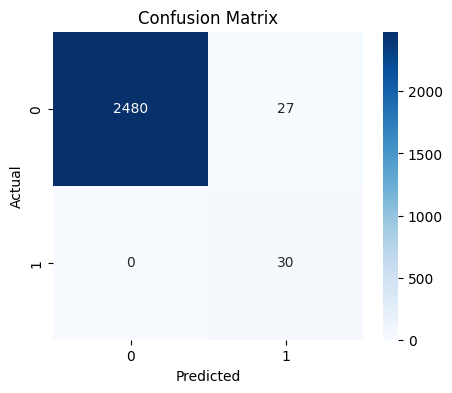

In [472]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels on test set
y_pred_labels = xgb_clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Optional: visualize nicely
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


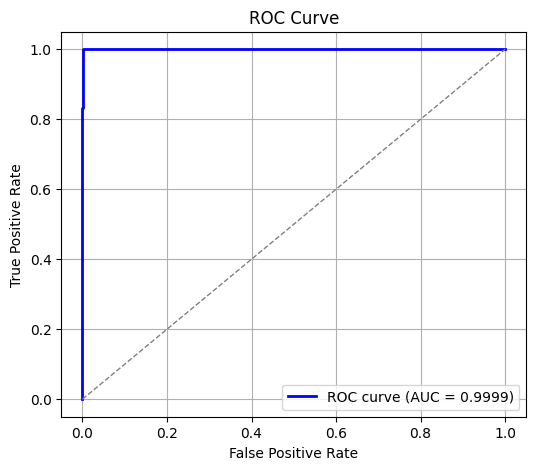

In [477]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for positive class
y_pred_proba = xgb_clf.predict_proba(X_test)[:,1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [475]:
import joblib

joblib.dump(xgb_clf, 'xgboost_woe_model.pkl')


['xgboost_woe_model.pkl']